In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
img_dir='real_hst/'
os.mkdir('JPG')
pos_dir='JPG/Positive/'
neg_dir='JPG/Negative/'
os.mkdir(pos_dir)
os.mkdir(neg_dir)
files=os.listdir(img_dir)
count=0
for im in files:
    if im.startswith('nl_'):
        save_dir=pos_dir   
        count+=1
        path=os.path.join(img_dir, im)
        img=np.load(path)
        img=(img * 255).astype(np.uint8)
        img=np.uint8(img)
        img=Image.fromarray(img)
        name=os.path.join(save_dir, f'{count}.jpg')
        img.save(name)
    else:
        save_dir=neg_dir   
        count+=1
        path=os.path.join(img_dir, im)
        img=np.load(path)
        img=(img * 255).astype(np.uint8)
        img=np.uint8(img)
        img=Image.fromarray(img)
        name=os.path.join(save_dir, f'{count}.jpg')
        img.save(name)

/tmp/ipykernel_8642/3223643980.py:25: RuntimeWarning: invalid value encountered in cast
  img=(img * 255).astype(np.uint8)
/tmp/ipykernel_8642/3223643980.py:15: RuntimeWarning: invalid value encountered in cast
  img=(img * 255).astype(np.uint8)


In [20]:
## We use Resnet-18 backbone for feature extraction. So remove fc layer which performs classification
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()

    def forward(self, x):
        return self.resnet(x)

In [21]:
## Projects the features and Learns contrastive features
class ContrastiveModel(nn.Module):
    def __init__(self, encoder):
        super(ContrastiveModel, self).__init__()
        self.encoder = encoder
        self.projection_head = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.projection_head(z)
        return z

In [6]:
device=("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
dataset = ImageFolder(root="JPG/", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
encoder = Encoder().to(device)
model = ContrastiveModel(encoder).to(device)

/home/susmit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/susmit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
criterion = nn.CosineEmbeddingLoss()

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
train, test=train_test_split(dataset, shuffle=True, test_size=0.1)

In [13]:
train_loader=DataLoader(train, batch_size=4, shuffle=True)

In [14]:
test_loader=DataLoader(test, batch_size=4, shuffle=False)

In [15]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        augmented_images = torch.flip(images, dims=[3])
        z = model(images)
        z_augmented = model(augmented_images)
        target = torch.ones(images.shape[0]).to(device) 
        loss = criterion(z, z_augmented, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/50: 100%|███████████████████████████████| 49/49 [00:03<00:00, 14.61it/s]


Epoch 1/50, Loss: 6.097555160522461e-05


Epoch 2/50: 100%|███████████████████████████████| 49/49 [00:02<00:00, 21.70it/s]


Epoch 2/50, Loss: 3.409385681152344e-05


Epoch 3/50: 100%|███████████████████████████████| 49/49 [00:02<00:00, 21.62it/s]


Epoch 3/50, Loss: 2.7060508728027344e-05


Epoch 4/50: 100%|███████████████████████████████| 49/49 [00:02<00:00, 21.55it/s]


Epoch 4/50, Loss: 1.049041748046875e-05


Epoch 5/50: 100%|███████████████████████████████| 49/49 [00:02<00:00, 21.52it/s]


Epoch 5/50, Loss: 2.3245811462402344e-05


Epoch 6/50: 100%|███████████████████████████████| 49/49 [00:02<00:00, 21.48it/s]


Epoch 6/50, Loss: 1.7702579498291016e-05


Epoch 7/50: 100%|███████████████████████████████| 49/49 [00:02<00:00, 21.46it/s]


Epoch 7/50, Loss: 1.9431114196777344e-05


Epoch 8/50: 100%|███████████████████████████████| 49/49 [00:02<00:00, 21.46it/s]


Epoch 8/50, Loss: 1.0311603546142578e-05


Epoch 9/50: 100%|███████████████████████████████| 49/49 [00:02<00:00, 21.42it/s]


Epoch 9/50, Loss: 8.106231689453125e-06


Epoch 10/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.43it/s]


Epoch 10/50, Loss: 5.7220458984375e-06


Epoch 11/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.41it/s]


Epoch 11/50, Loss: 1.3232231140136719e-05


Epoch 12/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.39it/s]


Epoch 12/50, Loss: 1.0907649993896484e-05


Epoch 13/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.36it/s]


Epoch 13/50, Loss: 3.933906555175781e-06


Epoch 14/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.34it/s]


Epoch 14/50, Loss: 3.2782554626464844e-06


Epoch 15/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.33it/s]


Epoch 15/50, Loss: 3.635883331298828e-06


Epoch 16/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.31it/s]


Epoch 16/50, Loss: 6.377696990966797e-06


Epoch 17/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.32it/s]


Epoch 17/50, Loss: 2.86102294921875e-06


Epoch 18/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.21it/s]


Epoch 18/50, Loss: 2.5033950805664062e-06


Epoch 19/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.27it/s]


Epoch 19/50, Loss: 2.2649765014648438e-06


Epoch 20/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.28it/s]


Epoch 20/50, Loss: 1.9073486328125e-06


Epoch 21/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.27it/s]


Epoch 21/50, Loss: 6.556510925292969e-07


Epoch 22/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.24it/s]


Epoch 22/50, Loss: 2.086162567138672e-06


Epoch 23/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.23it/s]


Epoch 23/50, Loss: 1.3113021850585938e-06


Epoch 24/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.24it/s]


Epoch 24/50, Loss: 5.543231964111328e-06


Epoch 25/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.23it/s]


Epoch 25/50, Loss: 1.7881393432617188e-06


Epoch 26/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.22it/s]


Epoch 26/50, Loss: 3.0994415283203125e-06


Epoch 27/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.22it/s]


Epoch 27/50, Loss: 1.2516975402832031e-06


Epoch 28/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.21it/s]


Epoch 28/50, Loss: 2.0265579223632812e-06


Epoch 29/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.20it/s]


Epoch 29/50, Loss: 8.940696716308594e-07


Epoch 30/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.20it/s]


Epoch 30/50, Loss: 4.76837158203125e-07


Epoch 31/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.19it/s]


Epoch 31/50, Loss: 1.8477439880371094e-06


Epoch 32/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.19it/s]


Epoch 32/50, Loss: 5.960464477539062e-07


Epoch 33/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.17it/s]


Epoch 33/50, Loss: 1.8477439880371094e-06


Epoch 34/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.18it/s]


Epoch 34/50, Loss: 1.0728836059570312e-06


Epoch 35/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.17it/s]


Epoch 35/50, Loss: 2.384185791015625e-06


Epoch 36/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.18it/s]


Epoch 36/50, Loss: 1.0728836059570312e-06


Epoch 37/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.14it/s]


Epoch 37/50, Loss: 1.4901161193847656e-06


Epoch 38/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.16it/s]


Epoch 38/50, Loss: 2.0265579223632812e-06


Epoch 39/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.16it/s]


Epoch 39/50, Loss: 1.0728836059570312e-06


Epoch 40/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.16it/s]


Epoch 40/50, Loss: 1.0728836059570312e-06


Epoch 41/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.15it/s]


Epoch 41/50, Loss: 1.0132789611816406e-06


Epoch 42/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.15it/s]


Epoch 42/50, Loss: 4.76837158203125e-07


Epoch 43/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.09it/s]


Epoch 43/50, Loss: 7.152557373046875e-07


Epoch 44/50: 100%|██████████████████████████████| 49/49 [00:03<00:00, 13.95it/s]


Epoch 44/50, Loss: 2.1457672119140625e-06


Epoch 45/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 20.37it/s]


Epoch 45/50, Loss: 9.5367431640625e-07


Epoch 46/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.17it/s]


Epoch 46/50, Loss: 8.940696716308594e-07


Epoch 47/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.15it/s]


Epoch 47/50, Loss: 1.7881393432617188e-06


Epoch 48/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.14it/s]


Epoch 48/50, Loss: 1.4901161193847656e-06


Epoch 49/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 21.16it/s]


Epoch 49/50, Loss: 1.3709068298339844e-06


Epoch 50/50: 100%|██████████████████████████████| 49/49 [00:02<00:00, 16.64it/s]

Epoch 50/50, Loss: 9.5367431640625e-07


In [16]:
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)[:, 1]
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probabilities.cpu().numpy())

In [17]:
roc_auc = roc_auc_score(y_true, y_scores)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.8823529411764706


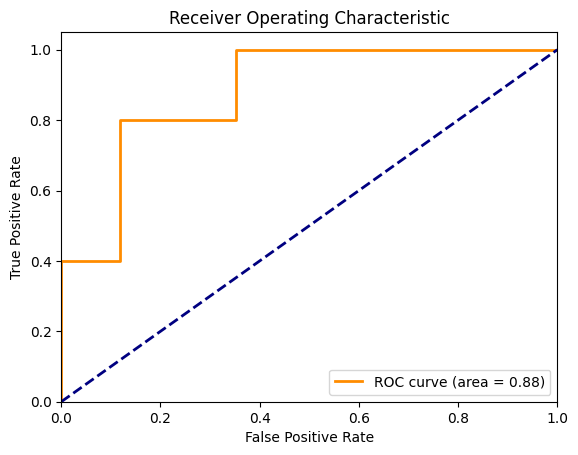

In [18]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [19]:
torch.save(encoder.state_dict(), "encoder.pth")